# Visualiser les inondations avec Sentinel 2

L'Organisation Météorologique Mondiale publiait en septembre 2019 un bilan du climat sur la période 2015-2019. Sans surprise, le réchauffement climatique semble s'accélérer et s'accompagne de son lot de catastrophes naturelles. 90% des catastrophes naturelles recensées sur cette périodes sont d'origine climatique et météorologique. Parmi celles-ci, les plus fréquentes sont des tempêtes et inondations.  
La France métropolitaine n'a pas échappé aux inondations en 2019 : 9 évènements ont été observés cette année, engendrant des dégâts estimés à 485 millions €. 2020 ne semble pas échapper à la tendance : la tempête Gloria avait ouvert l'année, suivie de 11 évènements tempétueux en seulement un mois (début février à début mars). Depuis quelques jours, les territoires de l'ouest de la France subissent de nouveau des inondations suite à de fortes précipitations.

sources : 
* [Bilan statistique des catastrophes naturelles en France et dans le monde en 2019](https://www.catnat.net/donneesstats/catnat-analytics/bilans-statistiques-annuels/27159-bilan-statistique-des-catastrophes-naturelles-en-france-et-dans-le-monde-en-2019?start=1), Observatoire permanent des catastrophes naturelles et des risques naturels, 2020
* [État du climat mondial 2015-2019: le changement climatique s’accélère](https://public.wmo.int/fr/medias/communiqu%C3%A9s-de-presse/%C3%A9tat-du-climat-mondial-2015-2019-le-changement-climatique-s%E2%80%99acc%C3%A9l%C3%A8re), Organisation Météorologique Mondiale, 22 septembre 2019 
* [Saison des tempêtes hivernales en Europe de 2019-2020](https://fr.wikipedia.org/wiki/Saison_des_temp%C3%AAtes_hivernales_en_Europe_de_2019-2020)

Ce tutoriel retrace les étapes pour détecter et extraire sous fichiers vectoriels les zones inondées sur des images optiques Sentinel2. Ces images proviennent du programme européen d'observation de la Terre Copernicus et ont l'avantage d'être en open-data. Un autre gros avantage est leur haute résolution spatiale et temporelle : un même lieu est rephotographié tous les 5 jours avec une résolution spatiale de 10 mètres.

Le cas étudié à travers ce tutoriel est celui des inondations qui ont eu lieu dans le Sud-Ouest de la France suite à la tempête du 13 décembre 2019, nommée Toni par les services allemands.

### Principe

Le [_Normalized Difference Water Index_ (NDWI)](http://ceeserver.cee.cornell.edu/wdp2/cee6150/Readings/Gao_1996_RSE_58_257-266_NDWI.pdf) est un indice couramment utilisé pour mettre simplement en avant la présence de masses d'eau sur des images optiques. Il se définit par une combinaison des bandes verte et proche infrarouge :

$NDWI = \frac{V-PIR}{V+PIR}$

avec :
* $V$ la valeur du pixel dans la bande verte
* $PIR$ la valeur du pixel dans le proche infrarouge

Les masses d'eau sont généralement détectées pour des valeurs de NDWI positives.

Pour les images Sentinel2, les bandes à exploiter pour construire ces indices sont la bande B03 pour le vert et la bande B08 pour l'infrarouge.

![sentinel2_bands_10m](media/sentinel2_bands_10m.png)  
_Source : ESA_

Ces deux bandes vont donc être utilisées pour localiser les zones inondées dans le Sud-Ouest de la France suite à la tempête du 13 décembre 2019. Des images avant et après le passage de la tempête sont récupérées pour analyser l'ampleur du phénomène.

### Récupération des images

Les deux images utilisées ici datent du 10 décembre et du 15 décembre 2019, leur doux petit nom étant :
* T30TXP_20191210T110339
* T30TXP_20191215T110441

La première partie du nom correpond à sa localisation géographique (T + numéro de tuile selon la convention US-MGRS (US Military Grid Reference System), la seconde partie est l'horodatage de la prise de vue au format UTC (temps universel coordonné).

Les deux images sont trop lourdes pour être mises à disposition sur GitHub. 

Nous vous proposons deux options pour les télécharger :

##### 1. Télécharger sur les DIAS Copernicus ou sur SciHub. 
Ci-dessous les liens vers fichiers images, via SciHub :
  * [Image 10 décembre 2019](https://scihub.copernicus.eu/dhus/odata/v1/Products('7084f330-b5fc-4323-afd2-9f7b2bcc8549')/$value)

  * [Image 15 décembre 2019](https://scihub.copernicus.eu/dhus/odata/v1/Products('e1a5706b-bda2-4ea7-906c-832b1a54eb82')/$value)


##### 2. Utiliser la bibliothèque Python `sentinelsat`.
Cett bibliothèque permet de rechercher des images Sentinel selon certains critères ou avec leur identifiant et de les télécharger. Il vous faudra un compte sur SciHub.
Les identifiants des deux images sont les suivants :
* Image 10 décembre 2019 : `7084f330-b5fc-4323-afd2-9f7b2bcc8549`
* Image 15 décembre 2019 : `e1a5706b-bda2-4ea7-906c-832b1a54eb82`
  
Et le code pour les télécharger :
```python
from sentinelsat import SentinelAPI

api = SentinelAPI('user', 'password', 'https://scihub.copernicus.eu/dhus')
api.download('product_id')
```
Le produit téléchargé est placé dans le répertoire courant.

Quelque soit l'option choisie, vous obtenez deux fichiers .zip :
* `S2B_MSIL2A_20191210T110339_N0213_R094_T30TXP_20191210T122431.zip`
* `S2A_MSIL2A_20191215T110441_N0213_R094_T30TXP_20191215T122756.zip`

Décompressez ces fichiers et navigez jusqu'au répertoire `GRANULE/<nom_du_produit>/IMG_DATA/R10m` qui contient les les images qui nous intéressent.  
Comme vu précédemment, pour le calcul de l'indice NDWI, seules les données dans les bandes verte et infrarouge sont nécessaires, autrement appelées B03 et B08.  
Placez les images correspondantes, pour chacune des dates, dans le dossier `img`.

Vous aurez surement **besoin de libérer la mémoire** de votre machine de temps en temps à cause du volume des images. Pour ce faire, il suffit de lancer cette commande depuis une cellule du notebook :
```python
import gc
gc.collect()
```

### Mise en place de l'environnement de travail

**Import des bibliothèques**

* `rasterio` est une bibliothèque de manipulation de données rasters développée par Mapbox. C'est une version "pythonique" de la bibliothèque de référence pour le traitement raster, GDAL.
* `fiona`, `numpy` et `geopandas` pour la gestion de données spatiales
* `folium` and `matplotlib` pour la visualisation

In [1]:
import rasterio as rio
from rasterio.mask import mask
from rasterio.features import shapes

import fiona

import geopandas as gpd
import numpy as np

import folium

import matplotlib
import matplotlib.pyplot as plt

**Définition de fonctions utiles**

In [2]:
def save_to_file(filename, data, meta):
    """
    Permet de sauvegarder en geotiff les données indiquées en entrée.
    N'est valide que dans le cas où une seule bande de données est à sauver.
    
    filename : string, nom du fichier avec l'extension .tif
    data : numpy array, données à sauvegarder
    meta : dictionnary, métadonnées de l'image d'origine
    """
    
    meta.update({"driver": "GTiff",
                 'count': 1,
                 'dtype': 'float32'})
    
    data = data.reshape((1, data.shape[0], data.shape[1]))
    
    with rio.open(filename, "w", **meta) as dest:
        dest.write(data)

In [3]:
def plot_ndwi(ndwi, title, cmap):
    """
    Fonction d'affichage graphique d'indice tel que le NDWI.
    
    ndwi : numpy array, données à afficher
    title : string, titre de la figure
    cmap : string, échelle de couleur à appliquer, parmi celles disponibles avec Matplotlib
    """
    
    ## Initialise une figure
    fig, ax = plt.subplots(figsize=(15, 10))

    ## Affichage
    plot_ndwi = ax.imshow(ndwi[0], cmap=cmap)
    cbar = fig.colorbar(plot_ndwi, ax=ax, label="valeur du NDWI")
    ax.set_title(title, fontsize=15)
    ax.axis('off')

    plt.show();

### Traitements

**Ouverture des images**

In [4]:
# Ouverture des bandes verte (appelée `green`, correspond à la bande B03 de Sentinel2) 
# et proche infrarouge (appelée `nir`, correspond à la bande B08 de Sentinel2) pour le 10 décembre 2019
im_green_before = rio.open('img/T30TXP_20191210T110339_B03_10m.jp2')
im_nir_before = rio.open('img/T30TXP_20191210T110339_B08_10m.jp2')

# Ouverture des bandes verte et proche infrarouge pour le 15 décembre 2019
im_green_after = rio.open('img/T30TXP_20191215T110441_B03_10m.jp2')
im_nir_after = rio.open('img/T30TXP_20191215T110441_B08_10m.jp2')

**Visualisation de l'emprise spatiale**

In [5]:
# Extraction de l'emprise de l'image, sous forme de tableau numpy
footprint_mask = im_green_before.dataset_mask()

# Extraction des bords de l'emprise de l'image, sous la forme d'une géométrie ...
for geom, val in shapes(footprint_mask, transform=im_green_before.transform):
    # ... et reprojection de la géométrie en EPSG:4326
    geom = rio.warp.transform_geom(im_green_before.crs, 'EPSG:4326', geom, precision=6)
    
# Affichage de l'emprise sur une carte avec Folium
## Initialisation de la carte
footprint_map = folium.Map(
                [43.741076, -1.0706605],
                tiles='stamentoner',
                zoom_start=9)

## Ajout de l'emprise
folium.GeoJson(geom).add_to(footprint_map)

## Appel de la carte
footprint_map

**Calcul du NDWI**

In [6]:
def normalize(band):
    """
    Normalise une bande entre 0 et 255.
    
    band : numpy array, bande à normaliser
    """
    
    band_min, band_max = band.min(), band.max()
    normalized = ((band - band_min)/(band_max - band_min)) * 255
    return normalized.astype(int)

In [7]:
def compute_ndwi(green, nir):
    """
    Calcul le NDWI à partir des bandes `green` et `nir`,
    d'après la formule définie par McFeeters (1996).
    
    green : numpy array, donnée correspondant à la bande verte
    nir : numpy array, donnée correspondant à la bande proche infrarouge
    """
    
    nir = np.float32(normalize(nir))  # Normalise et convertit en float32
    green = np.float32(normalize(green))  # Normalise et convertit en float32
    ndwi = (green-nir)/(green+nir)
    return ndwi

Le NDWI est calculé pour les deux dates :

In [8]:
ndwi_before = compute_ndwi(im_green_before.read(1), im_nir_before.read(1))
ndwi_after = compute_ndwi(im_green_after.read(1), im_nir_after.read(1))

/home/pauline/anaconda3/envs/flooding_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Puis sauver en fichier `.tif`, pour de prochaines utilisations (visualisation dans QGIS, extraction d'informations, etc.) :

In [9]:
ndwi_after_filename = 'img/ndwi_20191215_10m.tif'
ndwi_before_filename = 'img/ndwi_20191210_10m.tif'

save_to_file(ndwi_before_filename, ndwi_before, im_green_before.meta)
save_to_file(ndwi_after_filename, ndwi_after, im_green_after.meta)

**Affichage des résultats**

L'emprise spatiale du NDWI va être redécoupée pour exclure l'océan Atlantique de l'analyse. Cette étape implique de repartir des fichiers `.tif` créés juste au-dessus, pour faciliter l'utilisation de la fonction `mask()` de rasterio.

In [10]:
# Ouverture des deux fichiers NDWI précédemment calculés
ndwi_before_im = rio.open(ndwi_before_filename)
ndwi_after_im = rio.open(ndwi_after_filename)

# Ouverture du fichier masque correspondant aux limites terrestres de la France
gdf_mask = gpd.read_file('data/france.geojson')

# Reprojection du masque dans la même projection que celle du NDWI
gdf_mask = gdf_mask.to_crs(crs=ndwi_after_im.crs)

# Récupération de la géométrie du masque
mask_shape = gdf_mask['geometry'][0]

# Découpe des rasters NDWI selon le masque, avec la fonction `mask()` de rasterio
# Ici la valeur des pixels sans donnée est définie à "nan": `nodate=np.nan`
ndwi_before_clip, ndwi_before_clip_transform = mask(dataset=ndwi_before_im , shapes=mask_shape, crop=True, nodata=np.nan)
ndwi_after_clip, ndwi_after_clip_transform = mask(dataset=ndwi_after_im , shapes=mask_shape, crop=True, nodata=np.nan)

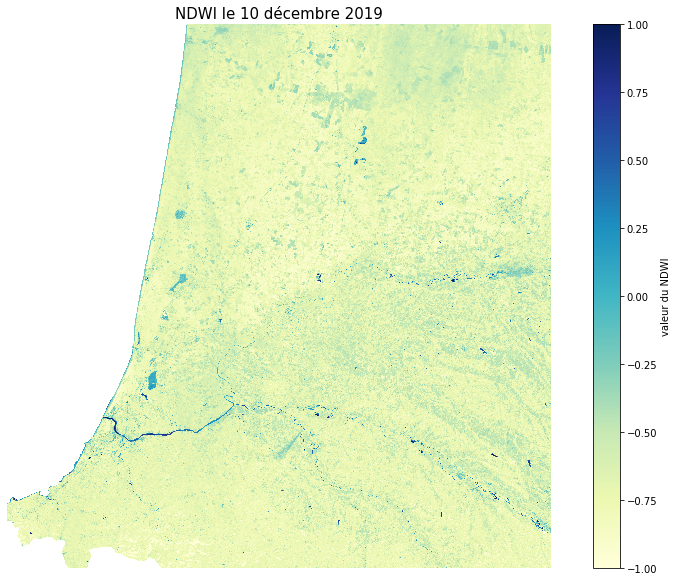

In [11]:
plot_ndwi(ndwi_before_clip, 'NDWI le 10 décembre 2019', "YlGnBu")

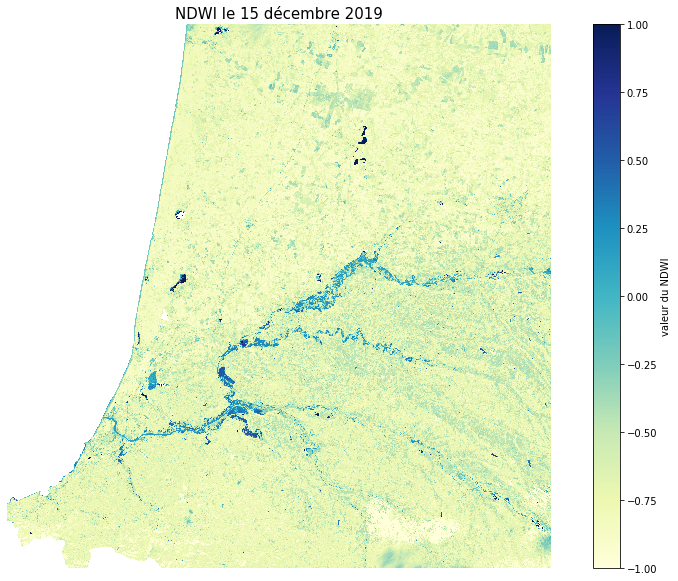

In [12]:
plot_ndwi(ndwi_after_clip, 'NDWI le 15 décembre 2019', "YlGnBu")

La comparaison du NDWI avant et après la tempête permet déjà de repérer les zones touchées par les inondations. L'analyse de l'échelle de couleur donne une indication sur la valeur du seuil à appliquer sur le NDWI pour isoler les zones inondées.

La soutraction du NDWI avant la tempête au NDWI après la tempête permet de mettre en avant les zones où des changements ont eu lieu, en l'occurence les valeurs positives de cette soustraction (en rouge ci-dessous) montrent les surfaces recouvertes d'eau le 15 décembre mais pas le 10.

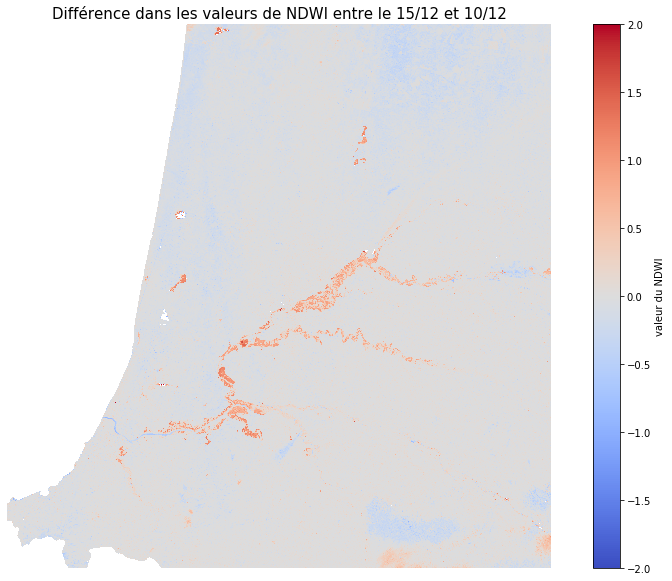

In [13]:
plot_ndwi(ndwi_after_clip-ndwi_before_clip, 'Différence dans les valeurs de NDWI entre le 15/12 et 10/12', 'coolwarm')

### Extraction des géométries des zones inondées

Par simple analyse visuelle des valeurs du NDWI affiché précédemment, le seuil de détection est défini à 0,1. Les valeurs du NDWI sont alors séparées en deux groupes distincts pour isoler les zones couvertes d'eau et extraire les géométries.  
Il serait aussi possible de partir des différences entre le NDWI après/avant et de n'extraire que les zones ou la différence est positive. Cela permettrait de n'afficher les surfaces inondées, où il n'y a pas d'eau habituellement, plutôt que toutes les surfaces couvertes d'eau.

In [14]:
def get_water_area(ndwi, ndwi_threshold):
    """
    Les pixels, du ndwi en entrée, dont la valeur est supérieure ou égale au seuil sont assignés à 1,
    les autres à `nan`.
    
    ndwi : numpy array, donnée à traiter
    ndwi_threshold : int ou float, seuil d'extraction
    """
    water_area = ndwi.copy()
    water_area[water_area < ndwi_threshold] = np.nan
    water_area[water_area >= ndwi_threshold] = 1
    
    return water_area

In [15]:
# Définition du seuil de détection des zones inondées
ndwi_threshold = 0.1

# Application du seuil
# Les zones inondées sont affectées à la valeur 1, les autres sont assignées à `nan`
water_area_before = get_water_area(ndwi_before_clip, ndwi_threshold)
water_area_after = get_water_area(ndwi_after_clip, ndwi_threshold)

/home/pauline/anaconda3/envs/flooding_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/home/pauline/anaconda3/envs/flooding_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


**Export en fichier spatial**

Les zones inondées sont exportées en GeoJSON, sous le nom `water_area_20191215.geojson`. Ce fichier est ensuite exploitable dans tout logiciel SIG ou sous Python avec des bibliothèques telles que GeoPandas.  
_Cette étape peut nécessiter un peu de temps, selon la puissance de votre machine._

In [16]:
# Création des géométries avec la fonction `shapes()` de rasterio.features
# Le paramètre `transform` précise la transformation affine à appliquer,
# pour passer des coordonnées dans la matrice aux coordonnées dans la projection associée.
water_shapes = list(shapes(water_area_after, transform=ndwi_after_clip_transform))

# Exporter en shape avec Fiona
with fiona.open(
    'water_area_20191215.geojson', 'w',
    crs={'init':'epsg:32630'},
    driver='GeoJSON',
    schema={'geometry': 'Polygon',
            'properties':{'id':'int'}}
) as shape:
    n = 0
    for polygon in water_shapes:
        if polygon[1]==1:  # Enregistre le polygone seulement s'il correpond à une zone inondée (= 1).
            shape.write({'geometry': polygon[0], 'properties':{'id': n}})
        n+=1